# $$\text{Application of Causal Inference Tools}$$

In [2]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.dml import LinearDMLCateEstimator, ForestDMLCateEstimator
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [4]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [5]:
# Define estimator inputs
train_data["log_demand"]=np.log(train_data["demand"])
train_data["log_price"]=np.log(train_data["price"])

X = train_data[["income"]]  # features

In [6]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

In [7]:
common_causes=["account_age","age","avg_hours","days_visited","friends_count",
               "has_membership","is_US","songs_purchased","income"]

In [8]:
model = CausalModel(
    data=train_data, 
    treatment='log_price', 
    outcome='log_demand', 
    common_causes=common_causes,
    effect_modifiers='income'
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['log_price'] on outcome ['log_demand']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


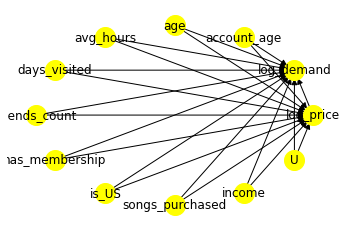

In [9]:
# Visualize causal graph

try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(Image(to_pydot(model._graph._graph).create_png()))
    
except:
    # Fall back on default graph view
    model.view_model()

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['account_age', 'songs_purchased', 'income', 'has_membership', 'is_US', 'age', 'friends_count', 'days_visited', 'avg_hours', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(log_demand|account_age,songs_purchased,income,has_mem
d[log_price]                                                                  

                                                        
bership,is_US,age,friends_count,days_visited,avg_hours))
                                                        
Estimand assumption 1, Unconfoundedness: If U→{log_price} and U→log_demand then P(log_demand|log_price,account_age,songs_purchased,income,has_membership,is_US,age,friends_count,days_visited,avg_hours,U) = P(log_demand|log_price,account_age,songs_purchased,income,has_membership,is_US,age,friends_count,days_visited,avg_hours)
### Estimand : 2
Estimand name: iv
No such variable found!



In [11]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [12]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [13]:
lineardml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDMLCateEstimator",
    control_value=0,
    treatment_value=1,
    target_units=X_test_data,
    method_params={
        "init_params": {"model_y": GradientBoostingRegressor(), 
                        "model_t": GradientBoostingRegressor(),
                        "featurizer":PolynomialFeatures(degree=2, include_bias=False)},
        "fit_params": {"inference": "statsmodels"},
    },
)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
est = lineardml_estimate._estimator_object
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test).flatten()
te_pred_interval = est.effect_interval(X_test)

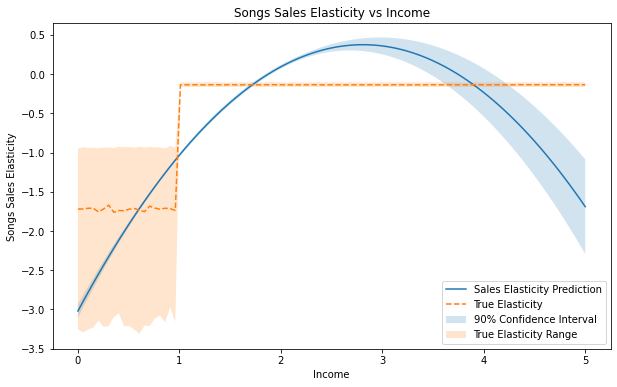

In [16]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right");

In [17]:
# Get the final coefficient and intercept summary
est.summary(feat_name=X.columns)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,2.417,0.086,28.172,0.0,2.276,2.558
income^2,-0.43,0.029,-14.585,0.0,-0.479,-0.382
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
intercept,-3.019,0.052,-57.893,0.0,-3.105,-2.934


In [18]:
forestdml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.ForestDMLCateEstimator",
    control_value=0,
    treatment_value=1,
    target_units=X_test_data.values,
    method_params={
        "init_params": {"model_y": GradientBoostingRegressor(), 
                        "model_t": GradientBoostingRegressor()},
        "fit_params": {"inference": "blb"},
    },
)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
est = forestdml_estimate._estimator_object
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test).flatten()
te_pred_interval = est.effect_interval(X_test)

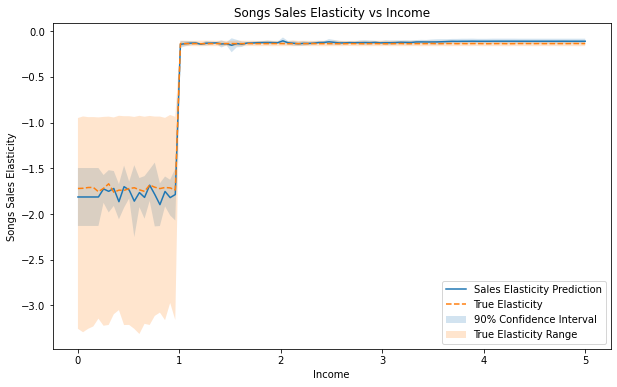

In [20]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right");

In [21]:
res_random = model.refute_estimate(identified_estimand, forestdml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours+w_random | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add a Random Common Cause
Estimated effect:-0.9634222159593084
New effect:-0.9666807589581092



In [22]:
res_unobserved = model.refute_estimate(
    identified_estimand,
    forestdml_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add an Unobserved Common Cause
Estimated effect:-0.9634222159593084
New effect:0.19825589289569848



In [23]:
res_placebo = model.refute_estimate(
    identified_estimand, forestdml_estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3)

print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 3 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~placebo+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~placebo

Refute: Use a Placebo Treatment
Estimated effect:-0.9634222159593084
New effect:-0.020743070949714924
p value:0.21286271662643919



In [24]:
res_subset = model.refute_estimate(
    identified_estimand, forestdml_estimate,
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)

print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 8000.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+account_age+songs_purchased+income+has_membership+is_US+age+friends_count+days_visited+avg_hours | income
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_demand~log_price+

Refute: Use a subset of data
Estimated effect:-0.9634222159593084
New effect:-0.9593069772948165
p value:0.22483334734579585



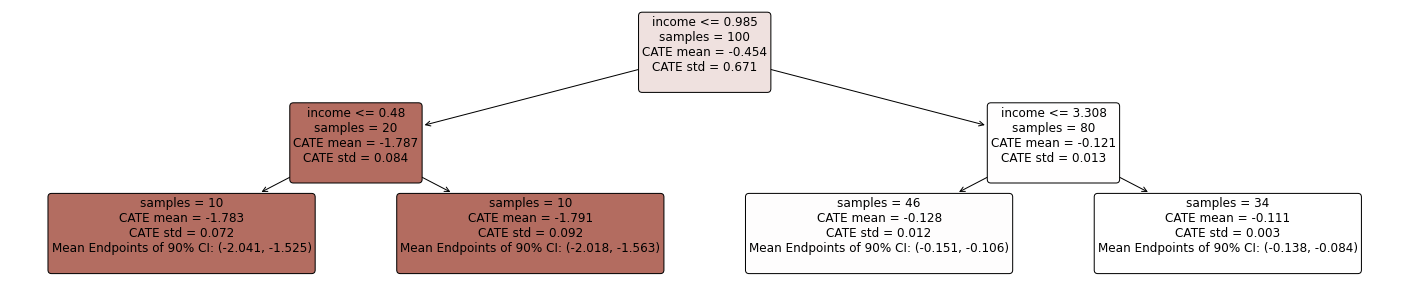

In [25]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

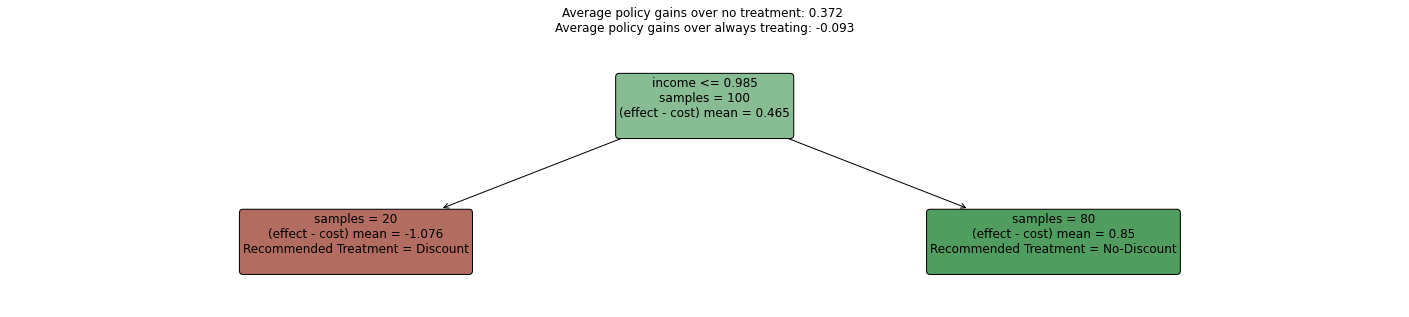

In [26]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est, X_test, sample_treatment_costs=-1, treatment_names=["Discount", "No-Discount"])
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

In [27]:
# define function to compute revenue
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [30]:
policy_dic = {}
# our policy above
policy = intrp.treat(X)
policy_dic["Our Policy"] = np.mean(
    revenue_fn(train_data, 0, 0.1, 1, policy))

## previous strategy
policy_dic["Previous Strategy"] = np.mean(
    train_data["price"] * train_data["demand"])

## give everyone discount
policy_dic["Give Everyone Discount"] = np.mean(
    revenue_fn(train_data, 0.1, 0, 1, np.ones(len(X))))

## don't give discount
policy_dic["Give No One Discount"] = np.mean(
    revenue_fn(train_data, 0, 0.1, 1, np.ones(len(X))))

## follow our policy, but give -10% discount for the group doesn't recommend to give discount
policy_dic["Our Policy + Give Negative Discount for No-Discount Group"] = np.mean(
    revenue_fn(train_data, -0.1, 0.1, 1, policy))

## give everyone -10% discount
policy_dic["Give Everyone Negative Discount"] = np.mean(
    revenue_fn(train_data, -0.1, 0, 1, np.ones(len(X))))

In [31]:
# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=["Revenue"])
res["Rank"] = res["Revenue"].rank(ascending=False)
res

,Revenue,Rank
Our Policy,14.686241,2.0
Previous Strategy,14.349342,4.0
Give Everyone Discount,13.774469,6.0
Give No One Discount,14.294606,5.0
Our Policy + Give Negative Discount for No-Discount Group,15.564411,1.0
Give Everyone Negative Discount,14.612670,3.0
